## Импорт необходимых библиотек и данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

Загрузка файла

In [ ]:
from google.colab import files
files.upload()

Перевод файла json в DataFrame

In [4]:
my_json = pd.read_json('data.json')

## Анализ данных

Посмотрим на полученный датасет. Он содержит 3 колонки:
id блюда - в данном случае неинформативная колонка
Название кухни, из которой исходит блюдо - наша целевая переменная
Ингридиенты, из которых состоит блюдо - данные в формате списка

In [5]:
my_json

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [6]:
type(my_json['ingredients'][5])

list

In [7]:
shape = my_json.shape
shape

(39774, 3)

Взглянем на популярность разных кухонь в имеющемся датасете

In [8]:
value_counts = my_json['cuisine'].value_counts()

In [9]:
value_counts

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

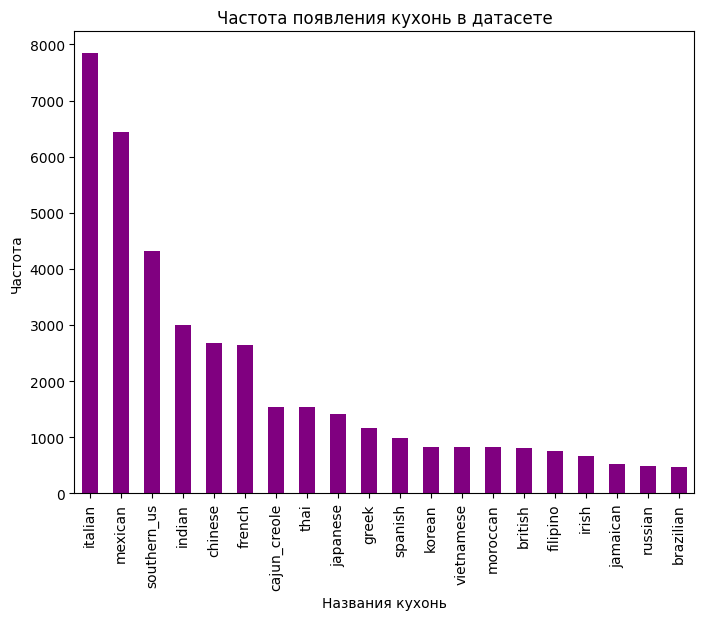

In [10]:
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='purple')
plt.title('Частота появления кухонь в датасете')
plt.xlabel('Названия кухонь')
plt.ylabel('Частота')
plt.show()

Посмотрим, какие ингридиенты являются самыми популярными для каждой кухни

In [11]:
dict_of_cuisines = {cuisine_name:dict() for cuisine_name in value_counts.index}

In [12]:
for i in range(shape[0]):
  current_cuisine = my_json['cuisine'][i]
  current_ingredients = my_json['ingredients'][i]
  for ingredient in current_ingredients:
    if ingredient in dict_of_cuisines[current_cuisine].keys():
      dict_of_cuisines[current_cuisine][ingredient] += 1
    else:
      dict_of_cuisines[current_cuisine][ingredient] = 1


In [13]:
dict_of_cuisines['italian']

{'sugar': 760,
 'pistachio nuts': 7,
 'white almond bark': 1,
 'flour': 142,
 'vanilla extract': 219,
 'olive oil': 3111,
 'almond extract': 56,
 'eggs': 627,
 'baking powder': 186,
 'dried cranberries': 8,
 'chopped tomatoes': 37,
 'fresh basil': 787,
 'garlic': 1471,
 'extra-virgin olive oil': 1362,
 'kosher salt': 656,
 'flat leaf parsley': 588,
 'pimentos': 16,
 'sweet pepper': 7,
 'dried oregano': 626,
 'sharp cheddar cheese': 9,
 'pepper': 965,
 'swiss cheese': 7,
 'provolone cheese': 138,
 'canola oil': 41,
 'mushrooms': 184,
 'black olives': 67,
 'sausages': 58,
 'Italian parsley leaves': 74,
 'walnuts': 38,
 'hot red pepper flakes': 76,
 'fresh lemon juice': 471,
 'trout fillet': 3,
 'garlic cloves': 1619,
 'chipotle chile': 2,
 'fine sea salt': 77,
 'fresh parmesan cheese': 251,
 'butter': 1030,
 'all-purpose flour': 918,
 'fat free less sodium chicken broth': 158,
 'chopped fresh chives': 68,
 'gruyere cheese': 18,
 'ground black pepper': 1444,
 'bacon slices': 48,
 'gnocchi

In [14]:
def take_n_most_popular_ingredients(cuisine, n):
  return dict(sorted(cuisine.items(), key=lambda item: item[1], reverse=True)[:n])

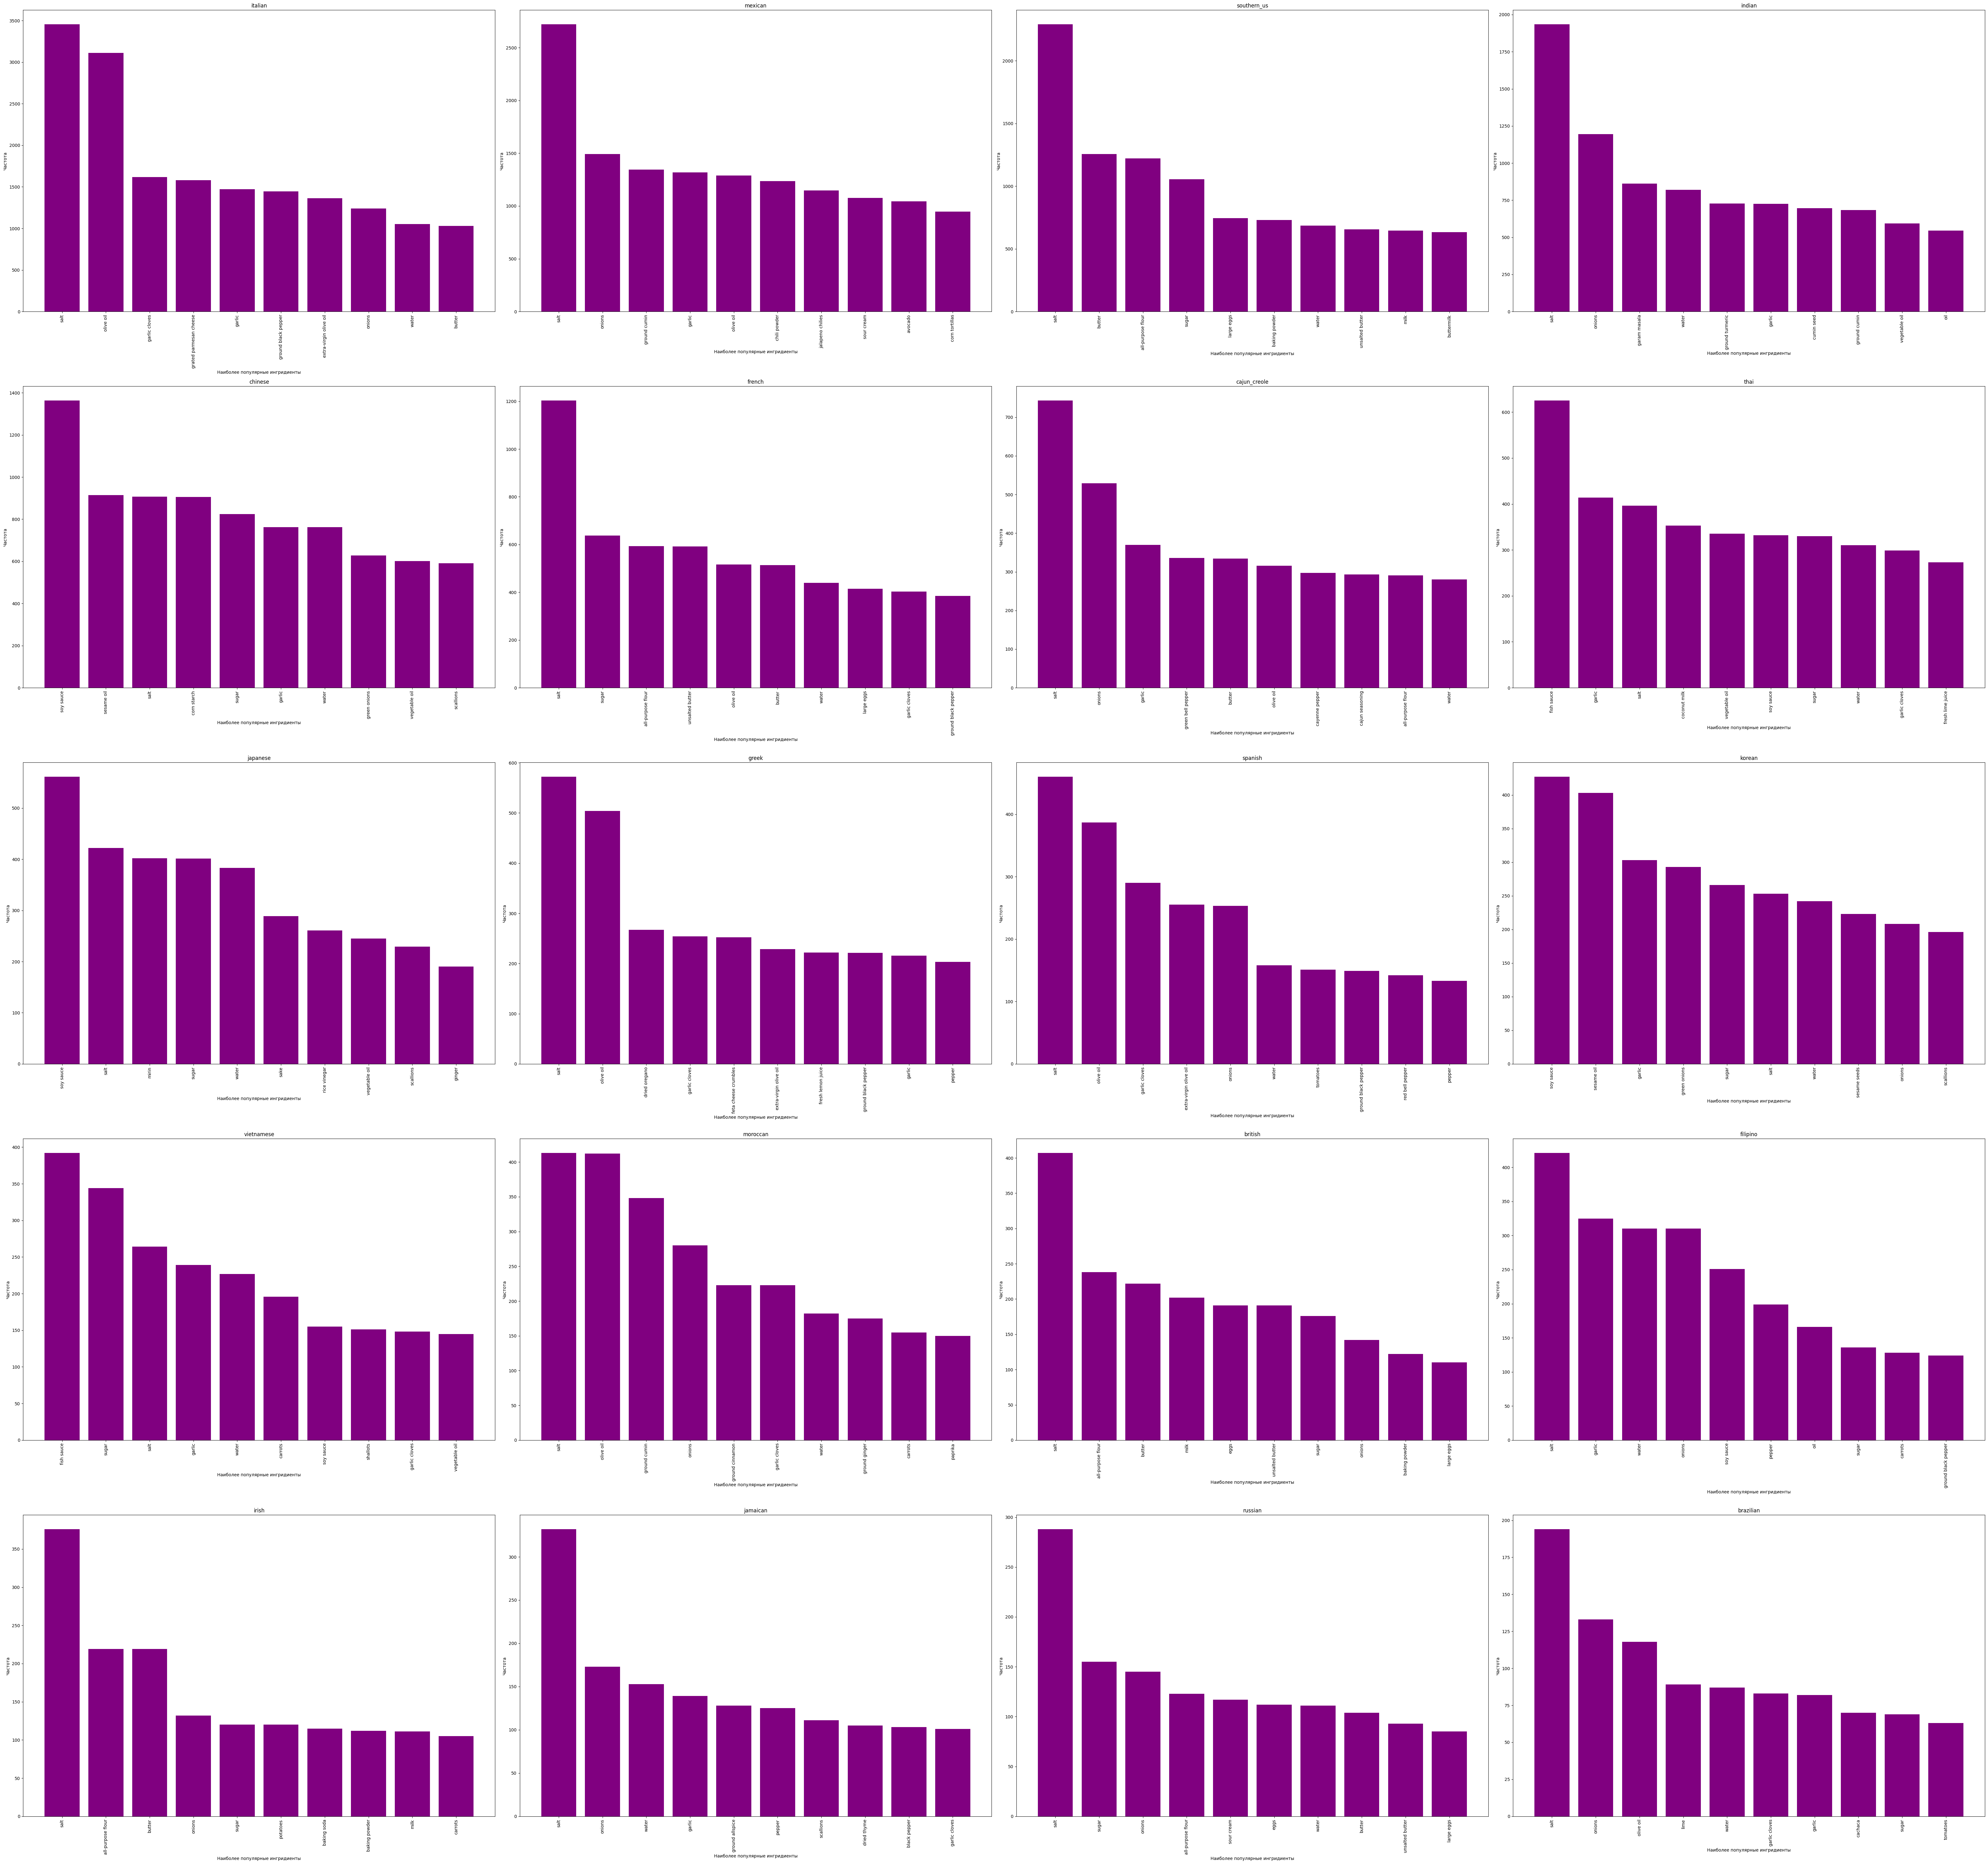

In [16]:
data = {cuisine:take_n_most_popular_ingredients(dict_of_cuisines[cuisine], 10) for cuisine in dict_of_cuisines}

fig, axs = plt.subplots(5, 4, figsize=(64, 60))

keys = list(data.keys())

for i in range(5):
    for j in range(4):
        if keys:
            key = keys.pop(0)
            value = data[key]
            current_keys = list(value.keys())
            current_values = list(value.values())
            axs[i, j].bar(current_keys, current_values, color='purple')
            axs[i, j].set_title(key)
            axs[i, j].set_xlabel('Наиболее популярные ингридиенты')
            axs[i, j].set_ylabel('Частота')
            axs[i, j].tick_params(axis='x', labelrotation=90)


plt.tight_layout()
plt.show()

Попробуем понять, есть ли связь между длиной списка ингридиентов и названием кухни

In [17]:
cuisines_and_lenghts = {cuisine_name:[] for cuisine_name in value_counts.index}

In [18]:
cuisines = list(value_counts.index)

In [19]:
for i in range(shape[0]):
  current_cuisine = my_json['cuisine'][i]
  current_len = len(my_json['ingredients'][i])
  cuisines_and_lenghts[current_cuisine].append(current_len)

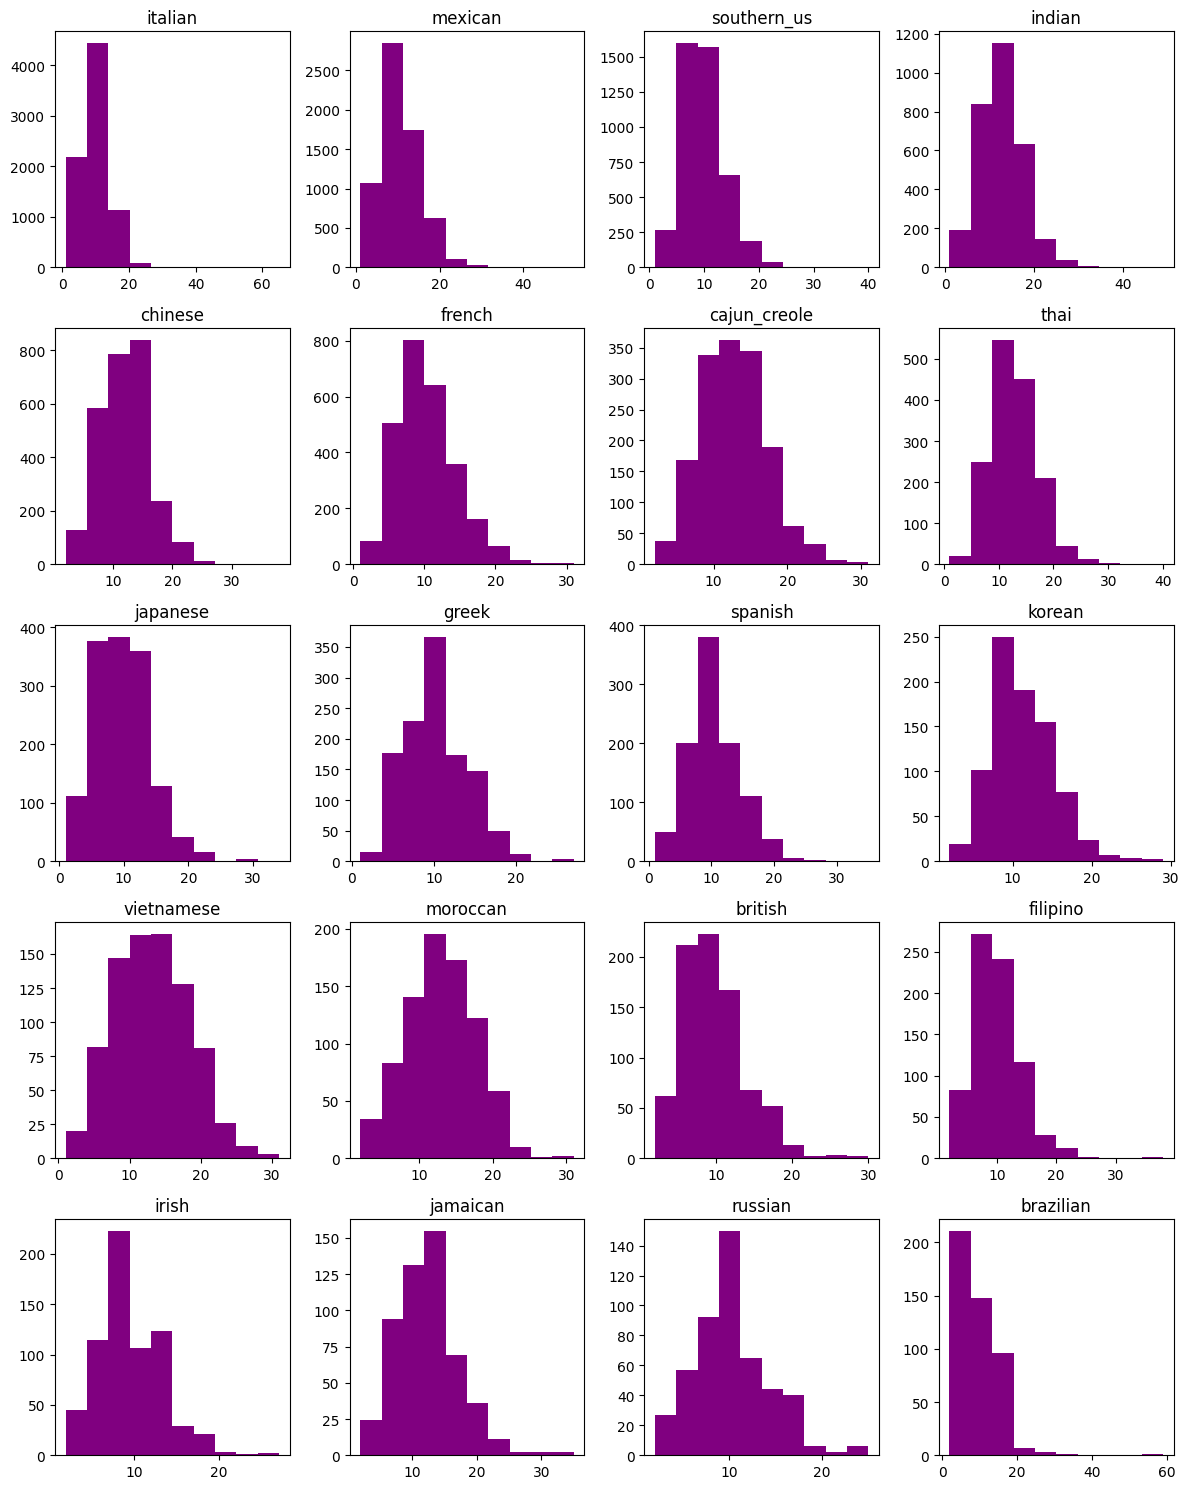

In [20]:
fig, axs = plt.subplots(5, 4, figsize=(12, 15))
flatten_axs = axs.flatten()

for i in range(20):
    ax = flatten_axs[i]
    current_cuisine = cuisines[i]
    ax.hist(cuisines_and_lenghts[current_cuisine], bins=10, color = 'purple')
    ax.set_title(f'{current_cuisine}')

plt.tight_layout()
plt.show()

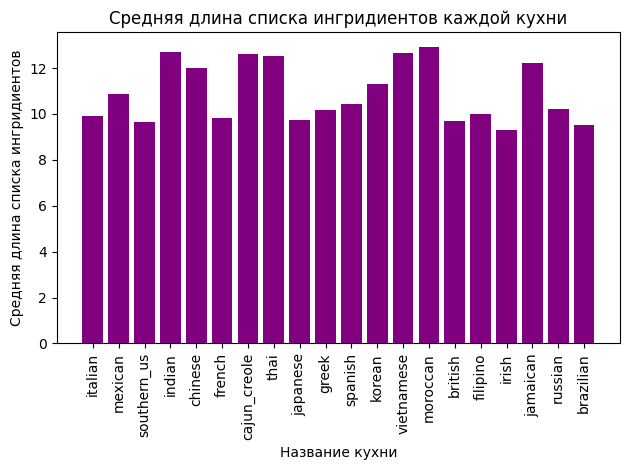

In [21]:
keys = cuisines
values = [np.mean(cuisines_and_lenghts[cuisine]) for cuisine in cuisines]


plt.bar(keys, values, color='purple')


plt.xlabel('Название кухни')
plt.ylabel('Средняя длина списка ингридиентов')
plt.title('Средняя длина списка ингридиентов каждой кухни')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Как видно, есть кухни, среднее количество ингридиентов в которых 12 и более, а есть и те, которых меньше 10

## Решение задачи

Несмотря на проделанный анализ, непонятно, как подступиться к задаче с имеющимися данными

Первое, что приходит на ум, чтобы прийти к классической задаче машинного обучения, это One-Hot-Encoding, но данный способ не самый лучший, так как создаёт разрезженную матрицу с огромным количеством признаков.

Вместо этого можно воспользоваться подходом tf-idf из NLP, рассматривая каждый список ингридиентов как один документ, а кухню - как тему, к которой принадлежит данный документ.

In [23]:
my_json['ingredients'] = my_json['ingredients'].apply(lambda x: ' '.join(x))
data = my_json['ingredients']
labels = my_json['cuisine']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=0, stratify = labels)


tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


#classifier = CatBoostClassifier()
#classifier.fit(X_train_tfidf, y_train)

#y_pred = classifier.predict(X_test_tfidf)

#accuracy = accuracy_score(y_test, y_pred)
#print(f"Точность модели: {accuracy}")

Сравним на этой задаче работу трёх разных методов машинного обучения для многоклассовой классификации, используя в качестве метрики качества accuracy.

In [30]:
# Логистическая регрессия
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)

accuracy_logreg = accuracy_score(y_test, y_pred)


# Наивный байесовский классификатор
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)

accuracy_NB = accuracy_score(y_test, y_pred)


# Градиентный бустинг
classifier = CatBoostClassifier(iterations = 200, learning_rate = 0.001)
classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_test_tfidf)

accuracy_catboost = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 2.9920724	total: 2.96s	remaining: 9m 50s
1:	learn: 2.9882138	total: 5.96s	remaining: 9m 49s
2:	learn: 2.9847154	total: 9.47s	remaining: 10m 22s
3:	learn: 2.9809566	total: 13.4s	remaining: 10m 54s
4:	learn: 2.9771908	total: 16.4s	remaining: 10m 37s
5:	learn: 2.9735285	total: 19.4s	remaining: 10m 25s
6:	learn: 2.9697290	total: 22.6s	remaining: 10m 24s
7:	learn: 2.9660951	total: 26.8s	remaining: 10m 44s
8:	learn: 2.9627082	total: 29.7s	remaining: 10m 31s
9:	learn: 2.9591394	total: 32.7s	remaining: 10m 20s
10:	learn: 2.9558140	total: 35.7s	remaining: 10m 14s
11:	learn: 2.9525567	total: 40.2s	remaining: 10m 29s
12:	learn: 2.9490856	total: 43.1s	remaining: 10m 20s
13:	learn: 2.9458256	total: 46.1s	remaining: 10m 12s
14:	learn: 2.9422336	total: 49.1s	remaining: 10m 4s
15:	learn: 2.9388169	total: 53.6s	remaining: 10m 16s
16:	learn: 2.9355165	total: 56.6s	remaining: 10m 8s
17:	learn: 2.9321375	total: 59.6s	remaining: 10m 2s
18:	learn: 2.9290245	total: 1m 2s	remaining: 9m 55s
19:	learn

In [31]:
print(f"Точность логистической регрессии: {accuracy_logreg}")
print(f"Точность байесовского классификатора: {accuracy_NB}")
print(f"Точность катбуста: {accuracy_catboost}")

Точность логистической регрессии: 0.7756641246962206
Точность байесовского классификатора: 0.6605212436101567
Точность катбуста: 0.4628341573786977


По результатам видно, что лучше всех себя показала, вопреки ожиданиям, логистическая регрессия. Скорее всего, дело в недостаточно качественной каллибровке гиперпараметров катбуст смог бы превзойти результат линейной модели. Но это уже совсем другая история....